In [38]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis"

In [2]:
from deg import *

In [3]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad'
#adata_with_features_file = 
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 87916 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [5]:
print(adata.X.min())
print(adata.X.max())
print(adata.X.mean())


0.0
8.285241
0.12131829


In [ ]:
# create a new obs for sex (take the first letter of the orig.ident)
#adata.obs['sex'] = adata.obs['orig.ident'].str[0]

In [ ]:
# cell_type_colors = {
#     'Fast IIB': '#FF9999',      # Light red/salmon
#     'Fast IIX': '#99C2FF',      # Light blue
#     'FAPs': '#99FFAB',          # Light green
#     'EC': '#E5B3FF',            # Light purple
#     'MTJ': '#FFB366',           # Light orange
#     'Pericyte': '#FFE4B5',      # Gold
#     'Skeleton MuSc': '#D4B499',  # Light brown
#     'NMJ': '#FFB3D9',           # Light pink
#     'Tendon': '#B3E6E6',        # Light cyan
#     'Macrophages': '#CCCCCC'    # Light gray
# }
# condition_colors = {
#     'WT': '#FFDAB9', # peachpuff
#     'KO': '#008080'     # Teal (darker)
# }
# sex_colors = {
#     'F': '#FFE4B5',   
#     'M': '#B8860B'    
# }

In [ ]:
# # Add the colors to adata
# adata.uns['cell_type_colors'] = [cell_type_colors[cell_type] for cell_type in adata.obs['cell_type'].cat.categories]
# adata.uns['condition_colors'] = [condition_colors[cond] for cond in adata.obs['condition'].cat.categories]
# adata.uns['sex_colors'] = [sex_colors[sex] for sex in adata.obs['sex'].cat.categories]

<Axes: title={'center': 'C_scANVI'}, xlabel='UMAP1', ylabel='UMAP2'>

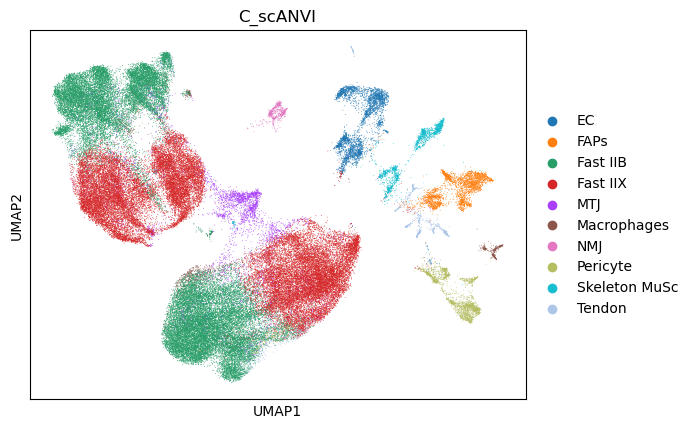

In [6]:
sc.pl.umap(adata, color=['C_scANVI'], show=False)

In [7]:
# get counts of obs C_scANVI
print(adata.obs['C_scANVI'].value_counts())


C_scANVI
Fast IIB         34755
Fast IIX         34393
MTJ               3718
EC                3561
FAPs              2735
Pericyte          2357
Skeleton MuSc     2004
Tendon            1486
Macrophages       1471
NMJ               1436
Name: count, dtype: int64


<Axes: title={'center': 'Δ ERCC1 KO cells'}, xlabel='UMAP1', ylabel='UMAP2'>

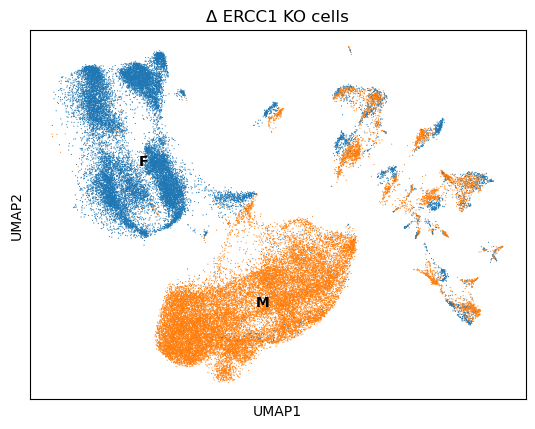

In [8]:
sc.pl.umap(adata[adata.obs['condition'] == 'KO'], color=['sex'], legend_loc='on data', show=False, title='Δ ERCC1 KO cells')

<Axes: title={'center': 'WT cells'}, xlabel='UMAP1', ylabel='UMAP2'>

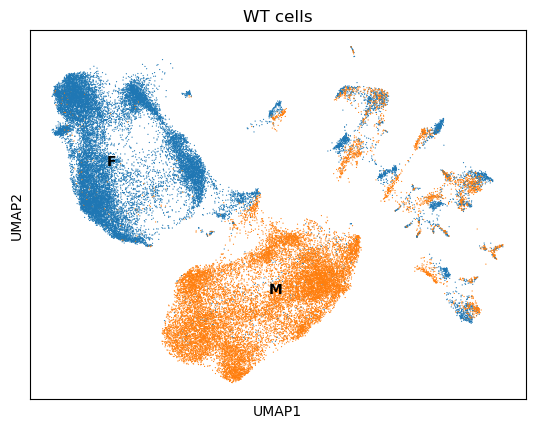

In [9]:
sc.pl.umap(adata[adata.obs['condition'] == 'WT'], color=['sex'], legend_loc='on data', show=False, title='WT cells')

# Cell population depletion/expansion analysis

#### Cells pooled from both sexes

In [10]:
results_df = get_cell_type_percentages(adata, cell_type_label='C_scANVI')
results_df_by_sex = get_cell_type_percentages_by_sex(adata, cell_type_label='C_scANVI')


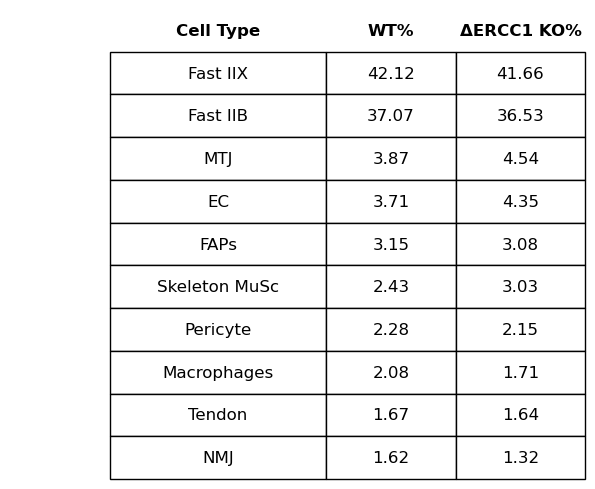

In [12]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))
ax.axis('off')

# Create table with more space on the left
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0.2, 0, 0.95, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
# Make headers bold and remove their edges
for col in range(len(results_df.columns)):
    header_cell = table[(0, col)]
    header_cell.set_text_props(weight='bold')
    header_cell.set_edgecolor('none')  # Remove cell borders for headers
    header_cell.set_facecolor('none')  # Remove cell background for headers
# Reduce row height and column width
for cell in table._cells:
    table._cells[cell].set_height(0.05)
    if cell[1] in [1, 2]:
        table._cells[cell].set_width(0.15)
    else:
        table._cells[cell].set_width(0.25)

# # Add colored dots with correct y-positions
# num_rows = len(results_df)
# for idx in range(num_rows):
#     cell_type = results_df['Cell Type'].iloc[idx]
    
#     # Calculate y position from top to bottom
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[C_scANVI_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# Set the plot limits explicitly to show the dots
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 5))  # Made wider to accommodate more columns
# ax.axis('off')
# # Create table with more space on the left
# table = ax.table(cellText=results_df_by_sex.values,
#                 colLabels=results_df_by_sex.columns,
#                 cellLoc='center',
#                 loc='center',
#                 bbox=[0.2, 0, 0.95, 1])

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(12)

# # Make headers bold
# for col in range(len(results_df_by_sex.columns)):
#     header_cell = table[(0, col)]
#     header_cell.set_text_props(weight='bold')
#     header_cell.set_edgecolor('none')  # Remove cell borders for headers
#     header_cell.set_facecolor('none')  # Remove cell background for headers

# # Reduce row height and adjust column widths
# # Reduce row height and column width
# for cell in table._cells:
#     table._cells[cell].set_height(0.05)
#     if cell[1] in [1, 2, 3, 4]:
#         table._cells[cell].set_width(0.15)
#     else:
#         table._cells[cell].set_width(0.25)

# # Add colored dots
# num_rows = len(results_df_by_sex)
# for idx in range(num_rows):
#     cell_type = results_df_by_sex['Cell Type'].iloc[idx]
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[cell_type_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# ax.set_xlim(0.1, 1)
# ax.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

# [Analysis] Get the DEGs

In [26]:
adata.X = adata.layers['cellbender'].copy()
# normalize counts on only HVGs
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm_cb"] = sc.pp.log1p(scales_counts["X"], copy=True)
#adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [28]:
adata.X = adata.layers['log1p_norm_cb']
print(adata.X.min())
print(adata.X.max())
print(adata.X.mean())


0.0
5.7404833
0.06094633


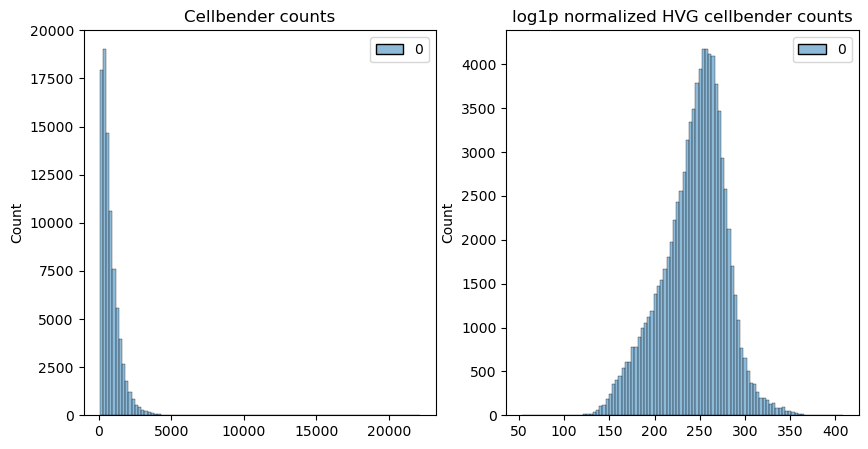

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.layers["cellbender"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Cellbender counts")
p2 = sns.histplot(adata.layers["log1p_norm_cb"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("log1p normalized HVG cellbender counts")
# p1 = sns.histplot(adata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
# axes[0].set_title("Counts")
# p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
# axes[1].set_title("Log1p normalized counts")
plt.show()

In [31]:
adata_male = adata[adata.obs['sex'] == 'M']
adata_female = adata[adata.obs['sex'] == 'F']

In [32]:
output_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis'
# Set scanpy settings
sc.settings.verbosity = 1
sc.settings.figdir = output_dir

## Cell type specific analysis

In [33]:
### DDR genes 
dna_damage_response = ['Atr', 'Atm', 'Chek1', 'Chek2', 'Trp53', 'Mdm2', 'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Xrcc6', 'Prkdc', 'Parp1', 'Xrcc1', 'Fancd2']

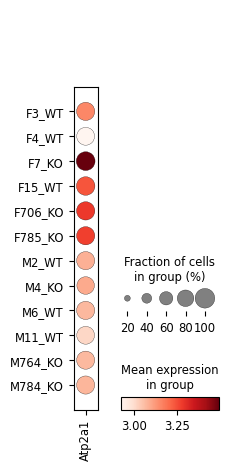

In [36]:
# check expression of Atp2a1 per sample dotplot
sc.pl.dotplot(
    adata,
    var_names=["Atp2a1"],
    groupby="sample_id"
)

In [39]:
# Run DEG analysis: KO vs WT for each cell type
cell_types = adata.obs['C_scANVI'].cat.categories
ko_wt_results = {}

for cell_type in cell_types:
    print(f"\nAnalyzing {cell_type}...")
    
    # Subset to specific cell type
    adata_subset = adata[adata.obs['C_scANVI'] == cell_type].copy()
    
    # Check sample sizes
    condition_counts = adata_subset.obs['condition'].value_counts()
    print(f"  Cells per condition: {condition_counts.to_dict()}")
    
    # Check if both KO and WT exist
    if 'KO' in condition_counts.index and 'WT' in condition_counts.index:
        if condition_counts['KO'] >= 10 and condition_counts['WT'] >= 10:  # Minimum cell threshold
            
            # Run differential expression
            sc.tl.rank_genes_groups(
                adata_subset,
                groupby='condition',
                groups=['KO'],
                reference='WT',
                method='wilcoxon',
                use_raw=False,
                pts=True,  # Calculate percent expressed
                key_added='KO_vs_WT'
            )
            
            # Extract results
            degs = sc.get.rank_genes_groups_df(adata_subset, group='KO', key='KO_vs_WT')
            
            # Add cell type column
            degs['cell_type'] = cell_type
            
            # Store results
            ko_wt_results[cell_type] = degs
            
            # Count significant genes
            sig_up = ((degs['pvals_adj'] < 0.05) & (degs['logfoldchanges'] > 0.5)).sum()
            sig_down = ((degs['pvals_adj'] < 0.05) & (degs['logfoldchanges'] < -0.5)).sum()
            print(f"  Significant DEGs: {sig_up} upregulated, {sig_down} downregulated")
            
            # Save individual file
            degs.to_csv(os.path.join(working_dir, f"DEGs_KO_vs_WT_{cell_type.replace(' ', '_').replace('/', '_')}.csv"), index=False)
        else:
            print(f"  Skipping - insufficient cells")
    else:
        print(f"  Skipping - missing KO or WT samples")

# Combine all results
if ko_wt_results:
    all_degs = pd.concat(ko_wt_results.values(), ignore_index=True)
    all_degs.to_csv(os.path.join(working_dir, "DEGs_KO_vs_WT_all_celltypes.csv"), index=False)
    print(f"\n✓ Analysis complete! Results saved for {len(ko_wt_results)} cell types")
else:
    print("\n✗ No valid comparisons found")

# Print summary table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for ct, degs in ko_wt_results.items():
    sig = degs['pvals_adj'] < 0.05
    up = (sig & (degs['logfoldchanges'] > 0.5)).sum()
    down = (sig & (degs['logfoldchanges'] < -0.5)).sum()
    print(f"{ct:20s} | ↑ {up:4d} | ↓ {down:4d} | Total: {len(degs):5d}")


Analyzing EC...
  Cells per condition: {'KO': 2048, 'WT': 1513}
  Significant DEGs: 0 upregulated, 8 downregulated

Analyzing FAPs...
  Cells per condition: {'KO': 1451, 'WT': 1284}
  Significant DEGs: 21 upregulated, 6 downregulated

Analyzing Fast IIB...
  Cells per condition: {'KO': 19634, 'WT': 15121}
  Significant DEGs: 36 upregulated, 51 downregulated

Analyzing Fast IIX...
  Cells per condition: {'KO': 17214, 'WT': 17179}
  Significant DEGs: 21 upregulated, 29 downregulated

Analyzing MTJ...
  Cells per condition: {'KO': 2139, 'WT': 1579}
  Significant DEGs: 8 upregulated, 11 downregulated

Analyzing Macrophages...
  Cells per condition: {'WT': 850, 'KO': 621}
  Significant DEGs: 37 upregulated, 46 downregulated

Analyzing NMJ...
  Cells per condition: {'KO': 775, 'WT': 661}
  Significant DEGs: 23 upregulated, 2 downregulated

Analyzing Pericyte...
  Cells per condition: {'KO': 1429, 'WT': 928}
  Significant DEGs: 30 upregulated, 7 downregulated

Analyzing Skeleton MuSc...
  Ce


Generating volcano plots...

Creating plot for EC...
  Saved: volcano_KO_vs_WT_EC.png


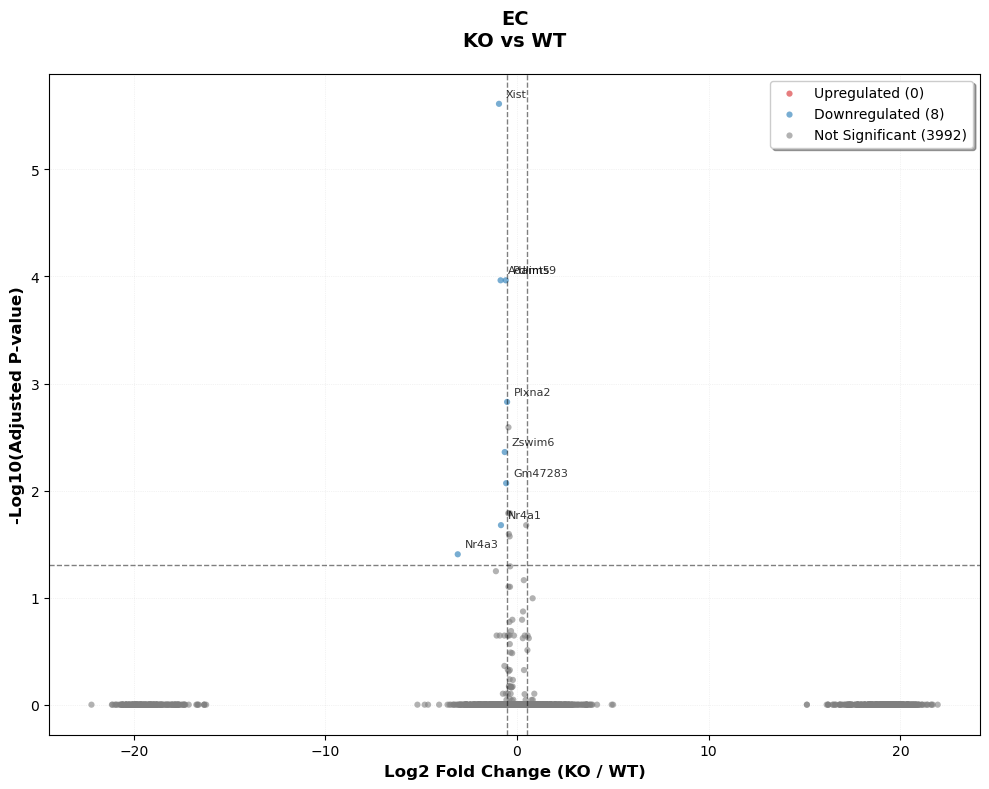


Creating plot for FAPs...
  Saved: volcano_KO_vs_WT_FAPs.png


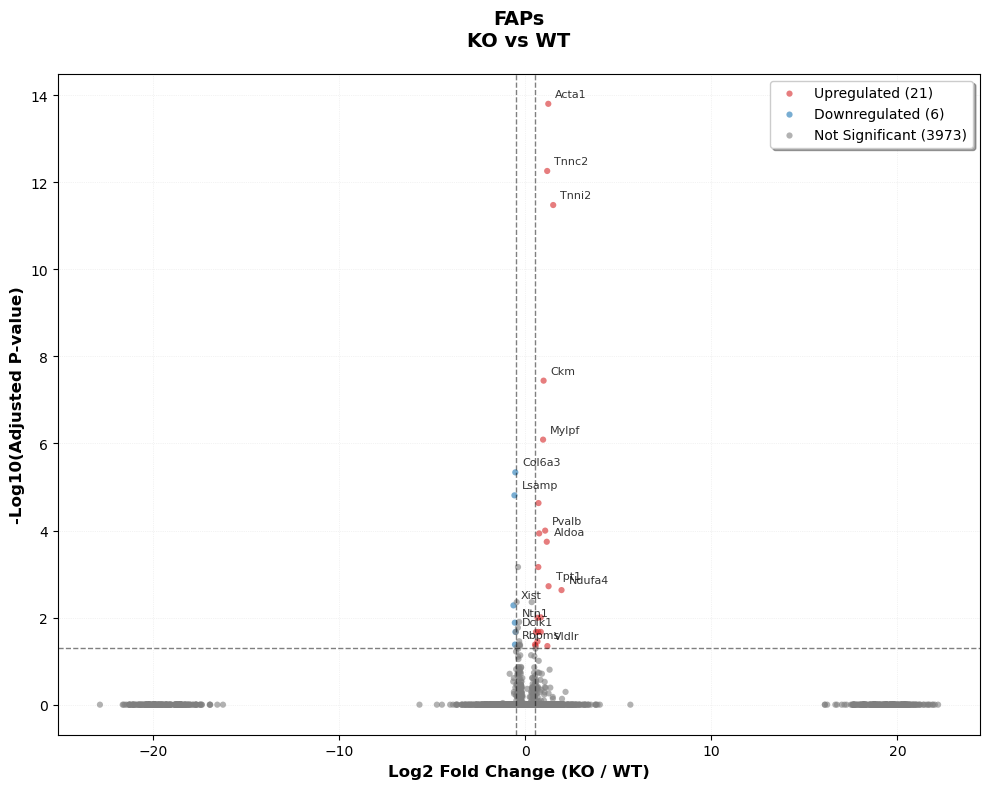


Creating plot for Fast IIB...
  Saved: volcano_KO_vs_WT_Fast_IIB.png


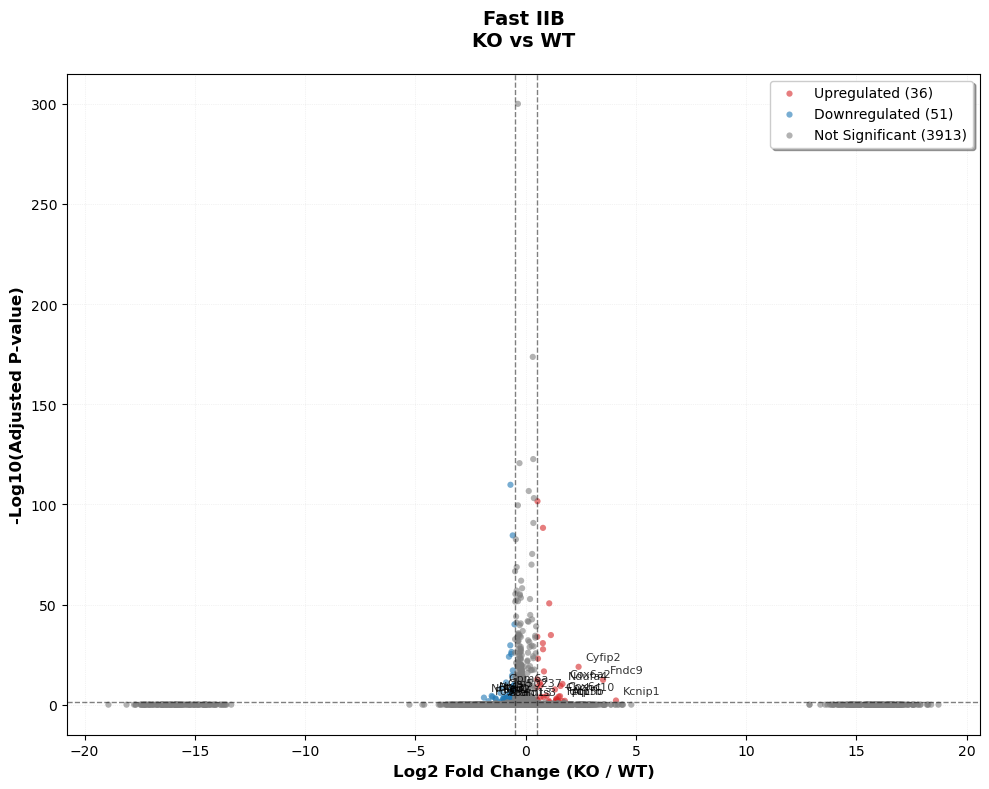


Creating plot for Fast IIX...
  Saved: volcano_KO_vs_WT_Fast_IIX.png


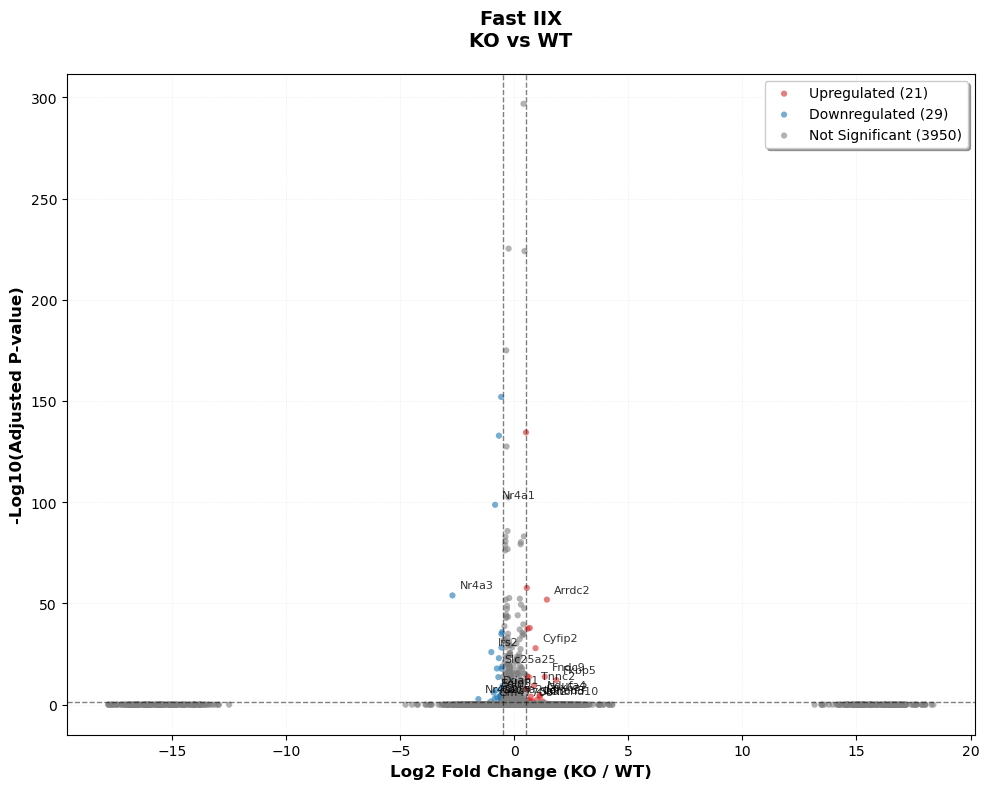


Creating plot for MTJ...
  Saved: volcano_KO_vs_WT_MTJ.png


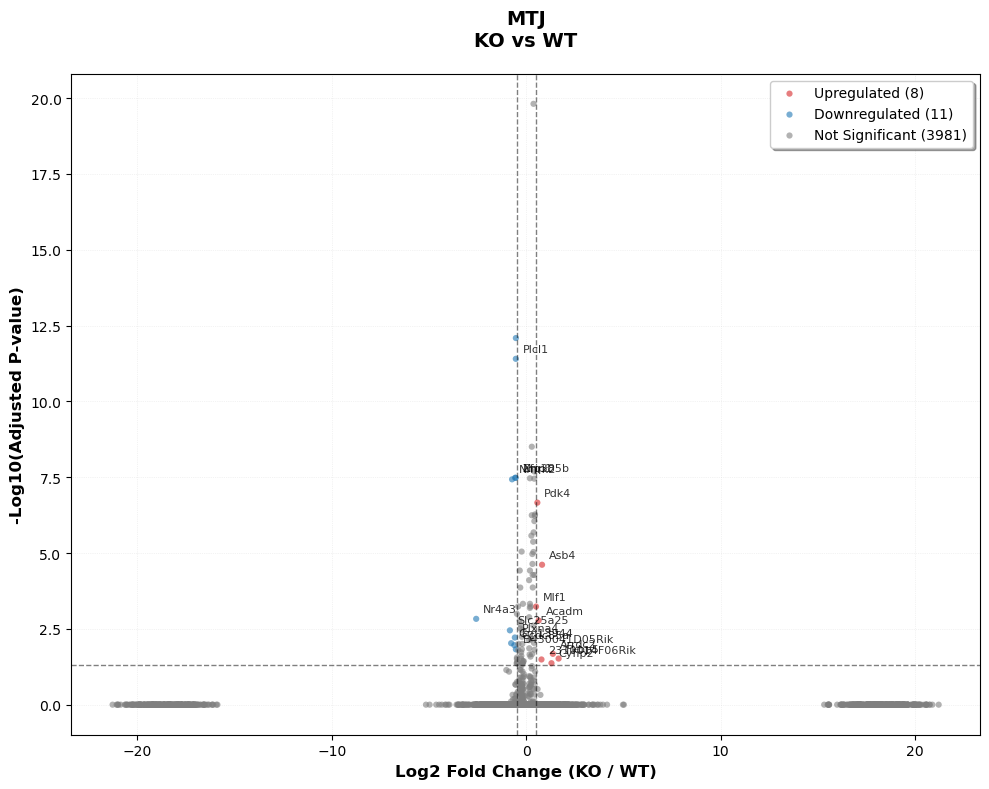


Creating plot for Macrophages...
  Saved: volcano_KO_vs_WT_Macrophages.png


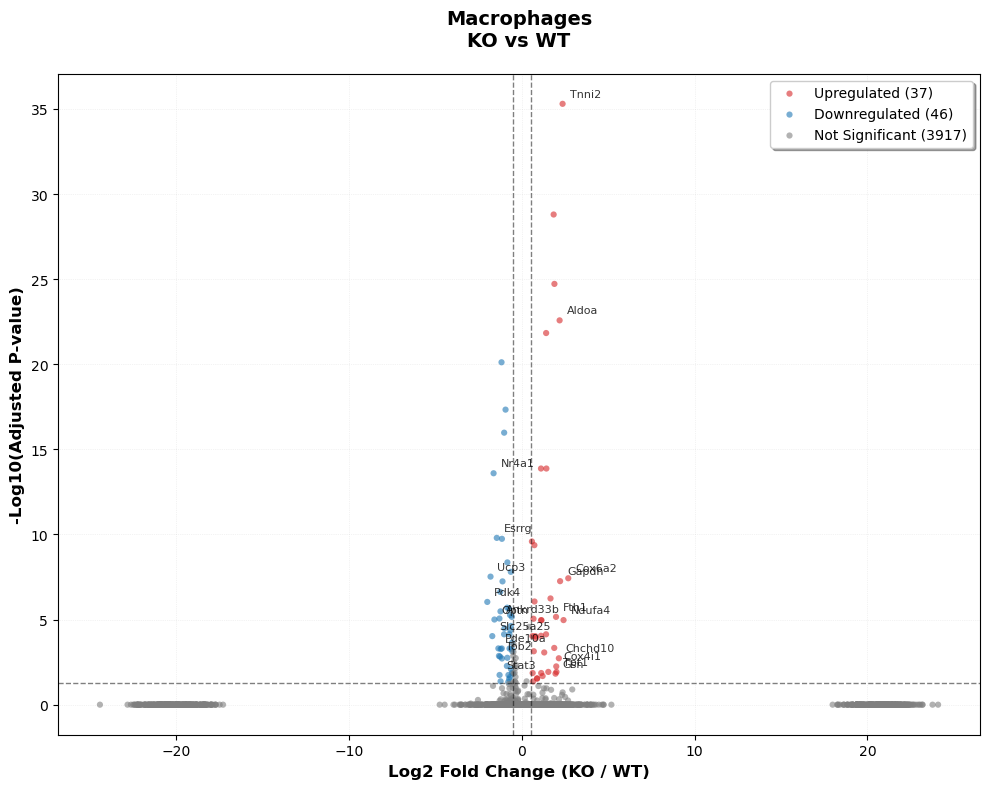


Creating plot for NMJ...
  Saved: volcano_KO_vs_WT_NMJ.png


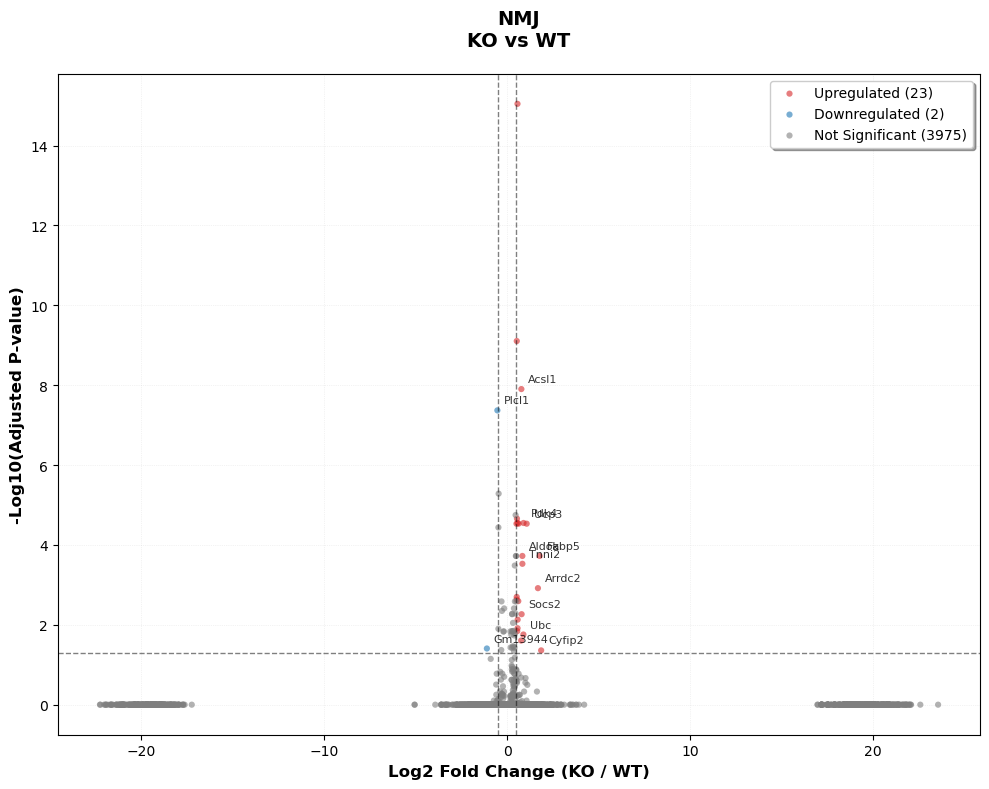


Creating plot for Pericyte...
  Saved: volcano_KO_vs_WT_Pericyte.png


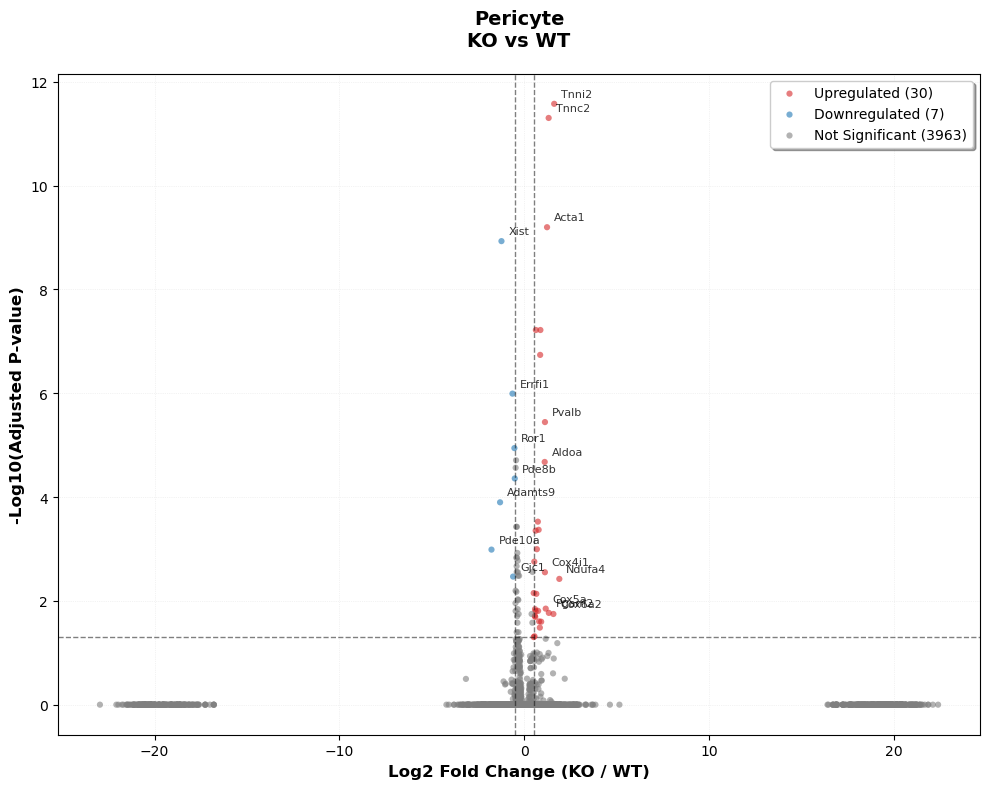


Creating plot for Skeleton MuSc...
  Saved: volcano_KO_vs_WT_Skeleton_MuSc.png


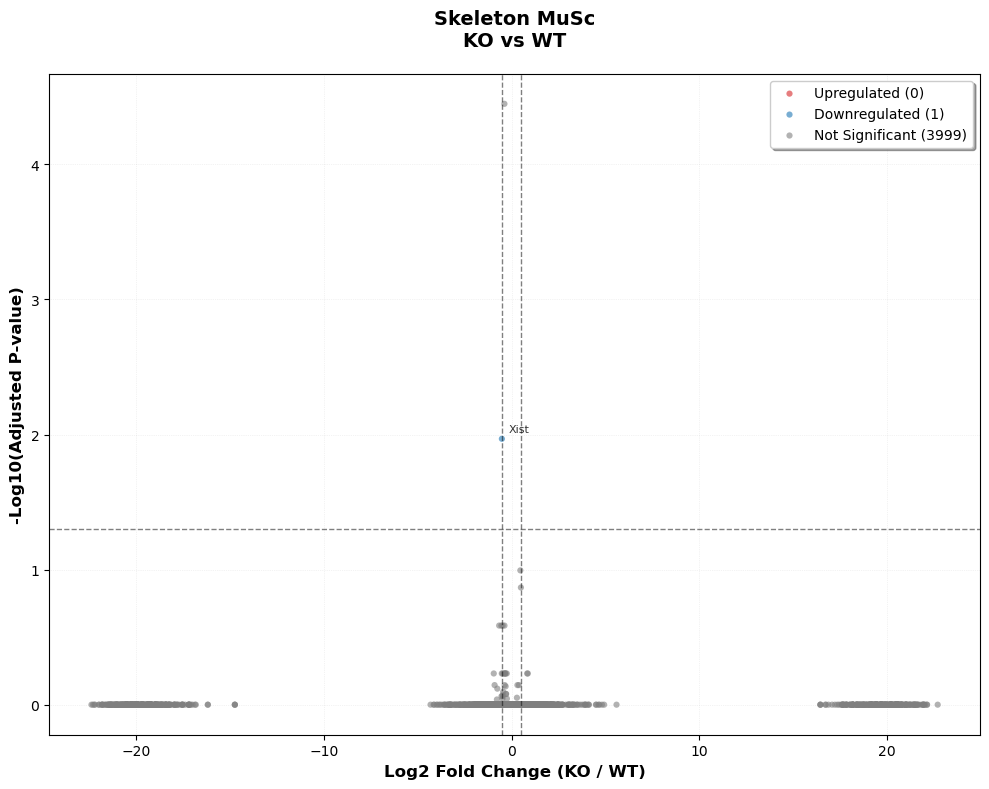


Creating plot for Tendon...
  Saved: volcano_KO_vs_WT_Tendon.png


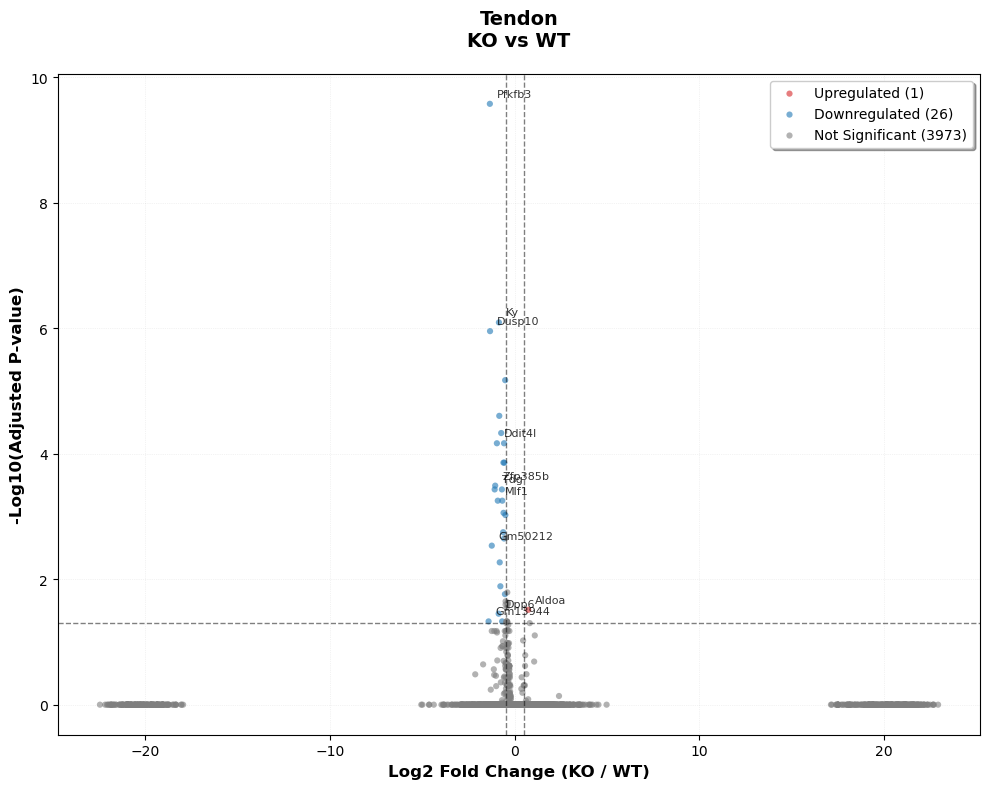


✓ All volcano plots generated!


In [47]:
def create_volcano_plot(degs, cell_type, top_n=10, save=True):
    """
    Create volcano plot for DEGs
    
    Parameters:
    -----------
    degs : DataFrame
        DEG results from scanpy
    cell_type : str
        Name of cell type
    top_n : int
        Number of top genes to label
    save : bool
        Whether to save the plot
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate -log10(p-value)
    degs['-log10_padj'] = -np.log10(degs['pvals_adj'].replace(0, 1e-300))  # Handle p=0
    
    # Define significance thresholds
    pval_thresh = 0.05
    fc_thresh = 0.5
    
    # Classify genes
    degs['significant'] = 'Not Significant'
    degs.loc[
        (degs['pvals_adj'] < pval_thresh) & (degs['logfoldchanges'] > fc_thresh),
        'significant'
    ] = 'Upregulated'
    degs.loc[
        (degs['pvals_adj'] < pval_thresh) & (degs['logfoldchanges'] < -fc_thresh),
        'significant'
    ] = 'Downregulated'
    
    # Color map
    colors = {'Upregulated': '#d62728', 'Downregulated': '#1f77b4', 'Not Significant': '#7f7f7f'}
    
    # Plot points
    for category, color in colors.items():
        mask = degs['significant'] == category
        ax.scatter(
            degs.loc[mask, 'logfoldchanges'],
            degs.loc[mask, '-log10_padj'],
            c=color,
            label=category,
            alpha=0.6,
            s=20,
            edgecolors='none'
        )
    
    # Add threshold lines
    ax.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(fc_thresh, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(-fc_thresh, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Label top genes
    sig_degs = degs[degs['significant'] != 'Not Significant'].copy()
    if len(sig_degs) > 0:
        # Top upregulated
        top_up = sig_degs[sig_degs['logfoldchanges'] > 0].nlargest(top_n, 'logfoldchanges')
        # Top downregulated
        top_down = sig_degs[sig_degs['logfoldchanges'] < 0].nsmallest(top_n, 'logfoldchanges')
        # Combine
        top_genes = pd.concat([top_up, top_down])
        
        for idx, row in top_genes.iterrows():
            ax.annotate(
                row['names'],
                xy=(row['logfoldchanges'], row['-log10_padj']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.8
            )
    
    # Count genes
    n_up = (degs['significant'] == 'Upregulated').sum()
    n_down = (degs['significant'] == 'Downregulated').sum()
    n_total = len(degs)
    
    # Labels and title
    ax.set_xlabel('Log2 Fold Change (KO / WT)', fontsize=12, fontweight='bold')
    ax.set_ylabel('-Log10(Adjusted P-value)', fontsize=12, fontweight='bold')
    ax.set_title(f'{cell_type}\nKO vs WT', fontsize=14, fontweight='bold', pad=20)
    
    # Add counts to legend
    legend_labels = [
        f'Upregulated ({n_up})',
        f'Downregulated ({n_down})',
        f'Not Significant ({n_total - n_up - n_down})'
    ]
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, legend_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Save
    if save:
        filename = f"volcano_KO_vs_WT_{cell_type.replace(' ', '_').replace('/', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"  Saved: {filename}")
    
    plt.show()
    plt.close()
    
    return fig, ax

# Generate volcano plots for all cell types
print("\nGenerating volcano plots...")
print("="*60)

for cell_type, degs in ko_wt_results.items():
    print(f"\nCreating plot for {cell_type}...")
    create_volcano_plot(degs, cell_type, top_n=10, save=True)

print("\n✓ All volcano plots generated!")

## Bulk-all cell types analysis

In [22]:
# Analyze Male Cells
print("Analyzing Male Cells...")
adata_male_filtered, male_deg_results = perform_deg_analysis(
    adata_male, 
    condition_column='condition',
    reference='WT', 
    comparison='KO',
    sex_label='Male', #used for naming the files
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

# Analyze Female Cells  
print("Analyzing Female Cells...")
adata_female_filtered, female_deg_results = perform_deg_analysis(
    adata_female,
    condition_column='condition',
    reference='WT',
    comparison='KO', 
    sex_label='Female',
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

Analyzing Male Cells...
=== Performing DEG Analysis: Male KO vs WT ===
Available conditions: ['KO', 'WT']
Categories (2, object): ['KO', 'WT']
Cells in analysis - WT: 18771
Cells in analysis - KO: 26017
Total genes analyzed: 1985
Significantly upregulated genes (padj < 0.05, |log2FC| > 0.5): 154
Significantly downregulated genes (padj < 0.05, |log2FC| > 0.5): 79
Analyzing Female Cells...
=== Performing DEG Analysis: Female KO vs WT ===
Available conditions: ['KO', 'WT']
Categories (2, object): ['KO', 'WT']
Cells in analysis - WT: 22016
Cells in analysis - KO: 21112
Total genes analyzed: 1985
Significantly upregulated genes (padj < 0.05, |log2FC| > 0.5): 48
Significantly downregulated genes (padj < 0.05, |log2FC| > 0.5): 160


/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


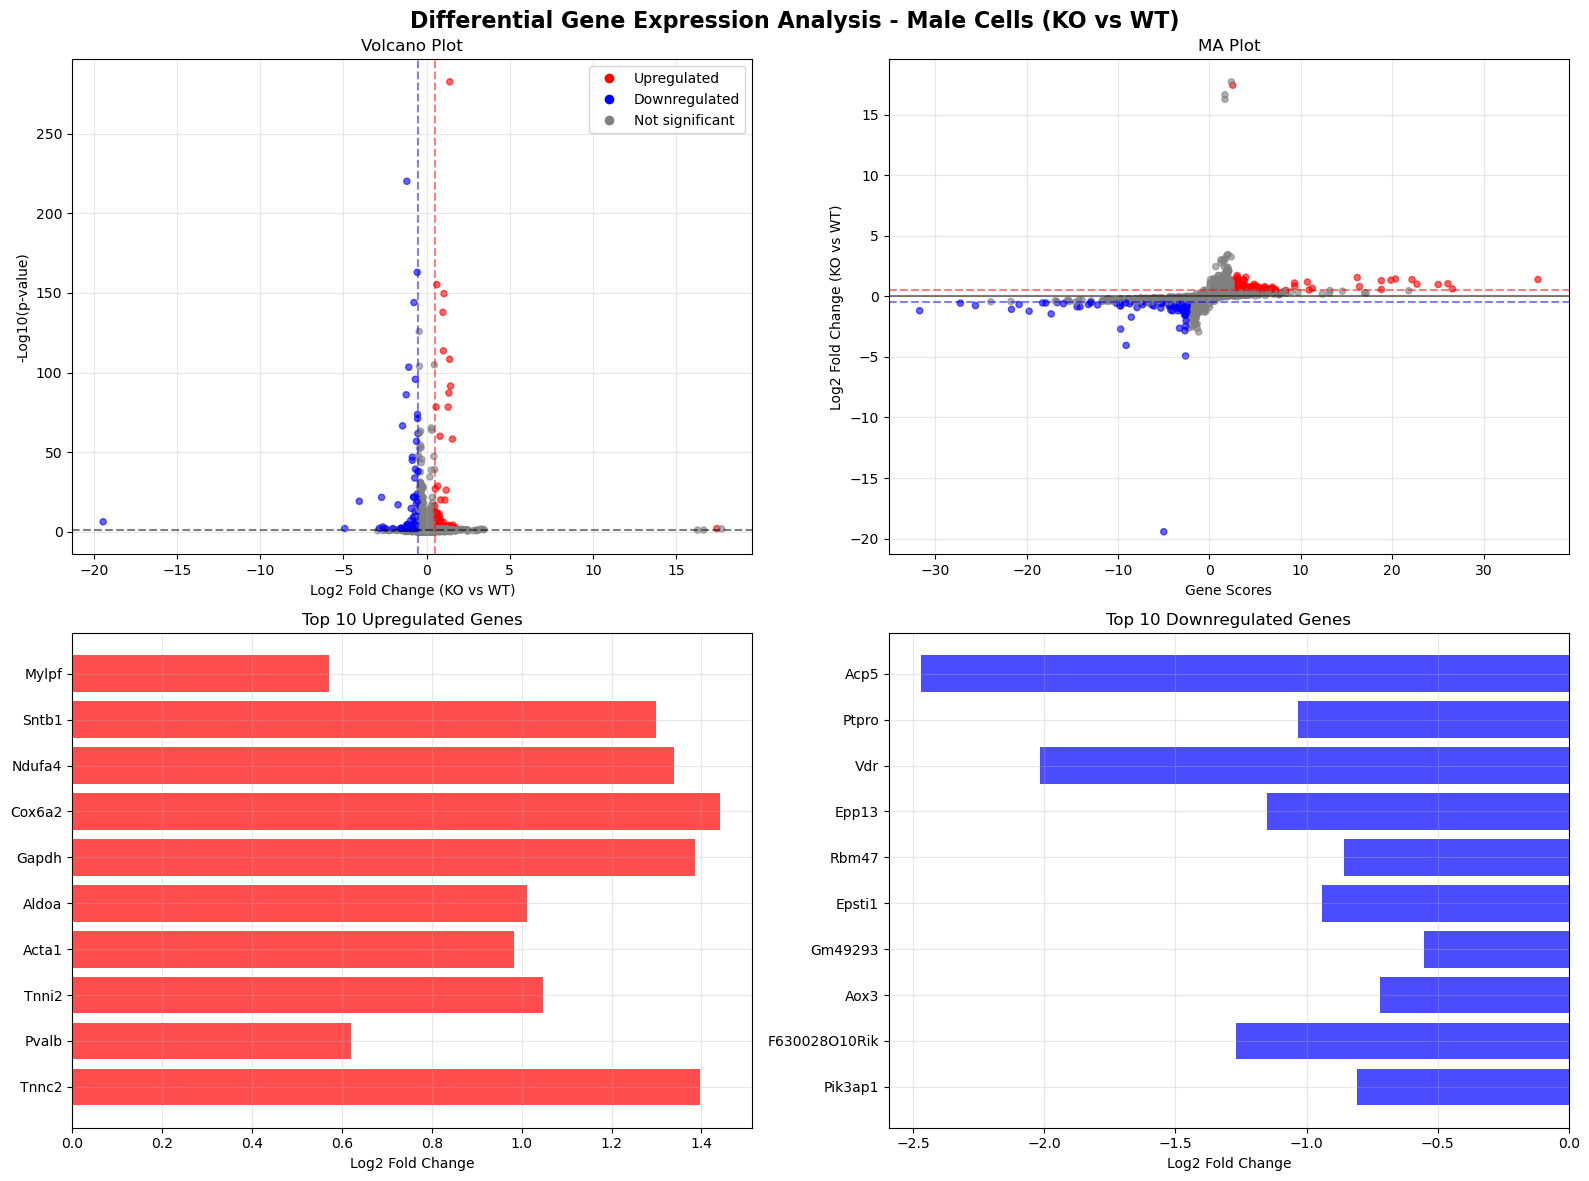

Visualization saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/DEG_analysis_male.png


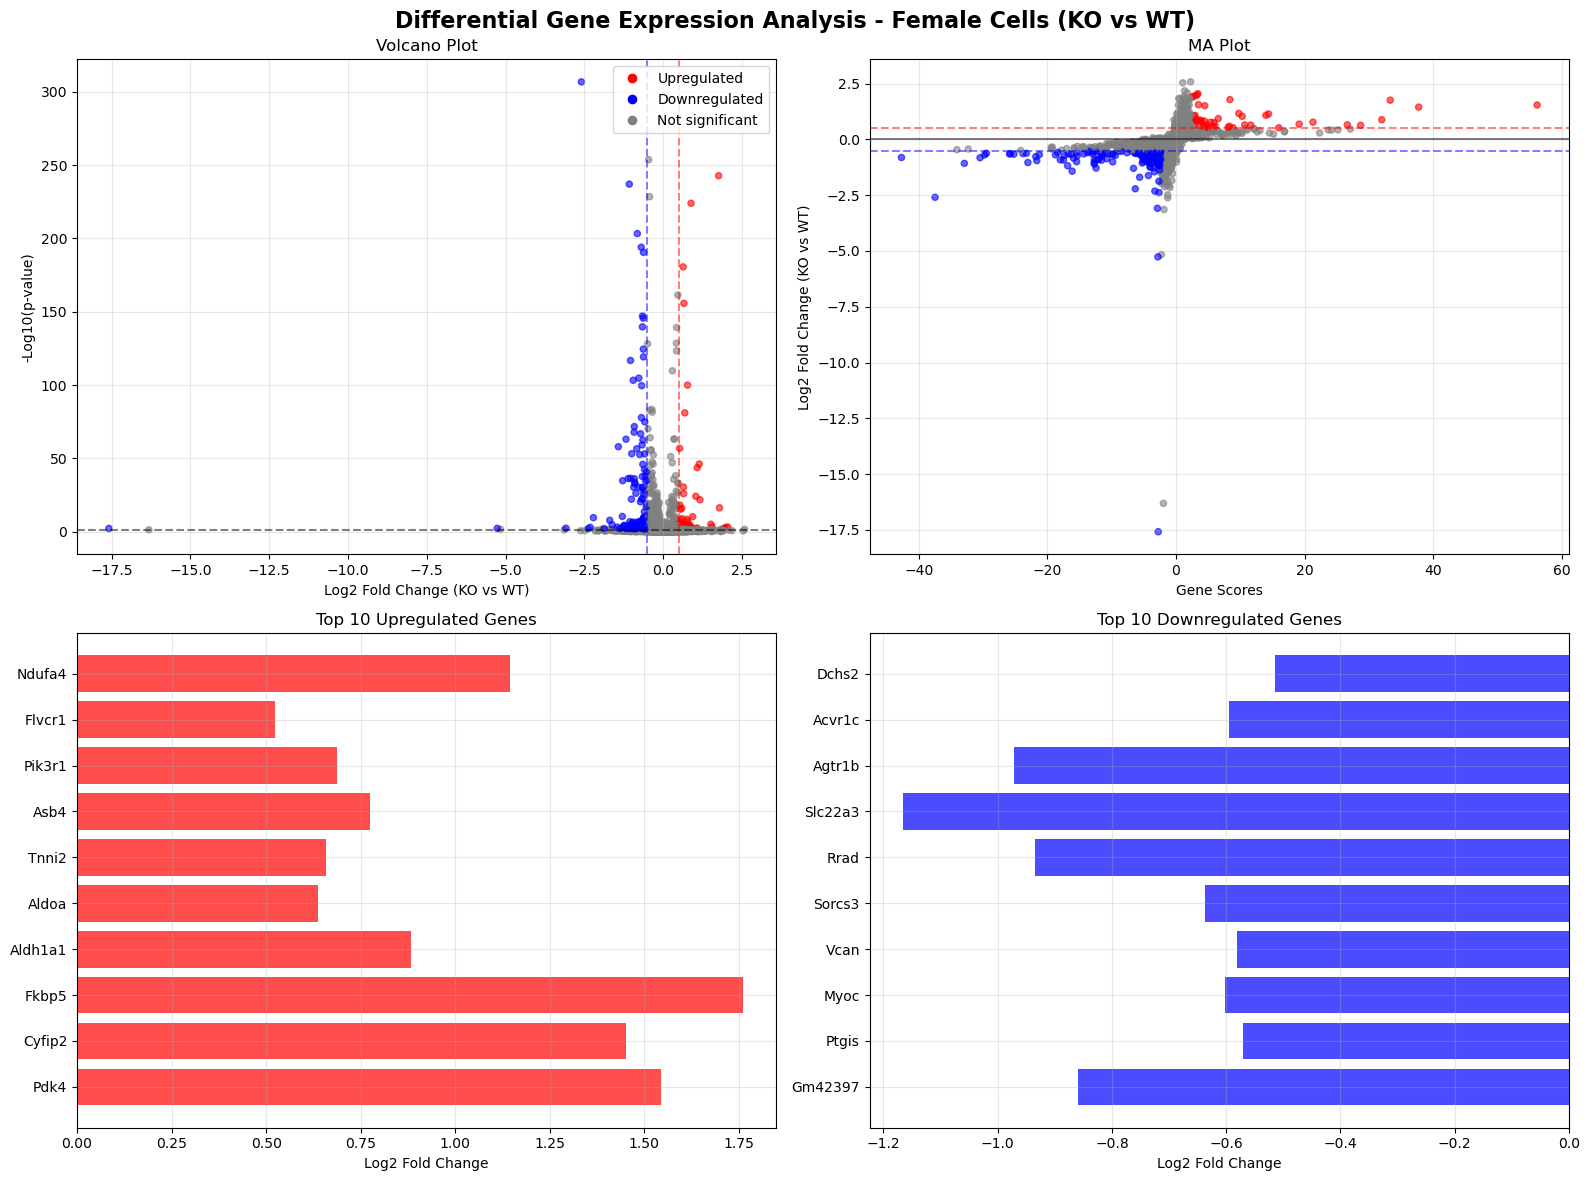

Visualization saved at: /ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/DEG_analysis_female.png


In [23]:
# Visualize and Save Results
if male_deg_results is not None:
    visualize_deg_results(male_deg_results, 'Male', output_dir)

if female_deg_results is not None:
    visualize_deg_results(female_deg_results, 'Female', output_dir)

In [ ]:
# save to csv
save_deg_results(male_deg_results, 'Male', output_dir)
save_deg_results(female_deg_results, 'Female', output_dir)


In [ ]:
if male_deg_results is not None and female_deg_results is not None:
    # Get significant genes with their regulation direction
    male_sig = male_deg_results[male_deg_results['significant']].copy()
    female_sig = female_deg_results[female_deg_results['significant']].copy()
    
    # Separate by regulation direction
    male_up = set(male_sig[male_sig['logfoldchanges'] > 0]['names'])
    male_down = set(male_sig[male_sig['logfoldchanges'] < 0]['names'])
    female_up = set(female_sig[female_sig['logfoldchanges'] > 0]['names'])
    female_down = set(female_sig[female_sig['logfoldchanges'] < 0]['names'])
    
    # Find common and sex-specific DEGs by regulation direction
    common_up = male_up.intersection(female_up)
    common_down = male_down.intersection(female_down)
    male_specific_up = male_up - female_up
    male_specific_down = male_down - female_down
    female_specific_up = female_up - male_up
    female_specific_down = female_down - male_down
    
    print(f"\n=== COMPARISON SUMMARY BY REGULATION ===")
    print(f"Common up-regulated DEGs: {len(common_up)}")
    print(f"Common down-regulated DEGs: {len(common_down)}")
    print(f"Male-specific up-regulated DEGs: {len(male_specific_up)}")
    print(f"Male-specific down-regulated DEGs: {len(male_specific_down)}")
    print(f"Female-specific up-regulated DEGs: {len(female_specific_up)}")
    print(f"Female-specific down-regulated DEGs: {len(female_specific_down)}")
    
    # Create DataFrame with gene names as rows
    # Find the maximum length to determine DataFrame size
    max_length = max(len(common_up), len(common_down), 
                    len(male_specific_up), len(male_specific_down),
                    len(female_specific_up), len(female_specific_down))
    
    # Create DataFrame with NaN padding
    comparison_df = pd.DataFrame({
        'common_up': list(common_up) + [np.nan] * (max_length - len(common_up)),
        'common_down': list(common_down) + [np.nan] * (max_length - len(common_down)),
        'male_specific_up': list(male_specific_up) + [np.nan] * (max_length - len(male_specific_up)),
        'male_specific_down': list(male_specific_down) + [np.nan] * (max_length - len(male_specific_down)),
        'female_specific_up': list(female_specific_up) + [np.nan] * (max_length - len(female_specific_up)),
        'female_specific_down': list(female_specific_down) + [np.nan] * (max_length - len(female_specific_down))
    })
    
    # Save the detailed comparison results
    comparison_file = 'DEG_sex_comparison_detailed.csv'
    comparison_df.to_csv(os.path.join(output_dir, comparison_file), index=False)
    print(f"Detailed sex comparison results saved at: {comparison_file}")
    
    # Also create a summary DataFrame
    summary_df = pd.DataFrame({
        'Category': ['Common up-regulated', 'Common down-regulated', 
                    'Male-specific up-regulated', 'Male-specific down-regulated',
                    'Female-specific up-regulated', 'Female-specific down-regulated'],
        'Count': [len(common_up), len(common_down), 
                 len(male_specific_up), len(male_specific_down),
                 len(female_specific_up), len(female_specific_down)]
    })

In [ ]:
# get a ranked genelist for pathway analysis
male_ranked_degs = create_ranked_genelist(male_deg_results, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names', min_pval=1e-300)
female_ranked_degs = create_ranked_genelist(female_deg_results, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names', min_pval=1e-300)
print(male_ranked_degs)


## Load pre-calculated DEGs

In [ ]:
# ########## file paths ##########
# output_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/pathways"
# #fast2b
# female_fast2b_path = os.path.join(working_dir, "Female_FastIIB_unfiltered_KO_DEGs.csv")
# male_fast2b_path = os.path.join(working_dir, "Male_Fast IIB_unfiltered_KO_DEGs_nmt.csv")
# #fast2x
# female_fast2x_path = os.path.join(working_dir, "Female_FastIIX_unfiltered_KO_DEGs.csv")
# male_fast2x_path = os.path.join(working_dir, "Male_Fast IIX_unfiltered_KO_DEGs_nmt.csv")
# # #faps
# # female_faps_path = os.path.join(working_dir, "Female_FAPs_unfiltered_KO_DEGs_nmt.csv")
# # male_faps_path = os.path.join(working_dir, "Male_FAPs_unfiltered_KO_DEGs_nmt.csv")
# # #musc
# # female_musc_path = os.path.join(working_dir, "Female_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")
# # male_musc_path = os.path.join(working_dir, "Male_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")


In [ ]:
# ############ load cell-type specific DEGs ############

# path_female_degs = female_fast2b_path
# path_male_degs = male_fast2b_path
# female_degs = pd.read_csv(path_female_degs, header=0)
# female_degs.rename(columns={female_degs.columns[0]: 'gene_name'}, inplace=True)
# male_degs = pd.read_csv(path_male_degs, header=0)
# male_degs.rename(columns={male_degs.columns[0]: 'gene_name'}, inplace=True)

In [ ]:
# gsea_female_degs = create_ranked_genelist(female_degs)
# gsea_male_degs = create_ranked_genelist(male_degs)

# Pathway analysis

In [43]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"
mhallmark_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/mh.all.v2024.1.Mm.symbols.gmt"

In [44]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
mhallmark = gmt_to_decoupler(mhallmark_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
n_unique_genesets_mhallmark = mhallmark['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")
print(f"Number of unique genesets: {n_unique_genesets_mhallmark}")

Number of unique genesets: 16059
Number of unique genesets: 50


In [45]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
geneset_size_mhallmark = mhallmark.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]
gsea_genesets_mhallmark = geneset_size_mhallmark.index[(geneset_size_mhallmark > 15) & (geneset_size_mhallmark < 500)]

### Select Pathways related to mitochondrial function

In [ ]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords)
]

display(len(selected_pathways))

In [ ]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

#### Run gsea

In [46]:
scores, norm, pvals = dc.run_gsea(
    fast_iib_degs,
    mhallmark,
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)
display(gsea_results.head())

ValueError: could not convert string to float: 'Tacc2'

In [ ]:
# First prepare your data
# gsea_results = gsea_results[~gsea_results.index.str.startswith('WP')]
gsea_results['-log10(pval)'] = -np.log10(gsea_results['pval'].replace(0, 1e-300))
gsea_results['Group'] = gsea_results['score'].apply(lambda x: 'Up' if x > 0 else 'Down')
# Create a copy with reset index to get the pathway names as a column
plot_df = gsea_results.reset_index().copy()
plot_df[['Gene_set', 'Name']] = plot_df['source'].str.extract(r'(GOBP|REACTOME|KEGG|HALLMARK|GOMF|GOCC|GRAESSMANN|WP)_(.+)')
plot_df['Name'] = plot_df['Name'].apply(lambda x: '_'.join(x.split('_')[:6]))
plot_df = plot_df.loc[plot_df.groupby('Name')['-log10(pval)'].idxmax()]
# copy source column to a new column called 'Term'
plot_df['Term'] = plot_df['source']
display(plot_df.head())


### Plotting the enrichment results

In [ ]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

In [ ]:
# Create simplified terms and group by them
plot_df['simple_term'] = plot_df['Term'].apply(simplify_term)
# Keep only the most significant pathway for each simplified term
plot_df = plot_df.loc[plot_df.groupby('simple_term')['-log10(pval)'].idxmax()]
# Sort to put Up group at top
plot_df = plot_df.sort_values(['Group', '-log10(pval)'], ascending=[True, False])

ax = gp.barplot(
    df=plot_df,
    column='-log10(pval)',
    group='Group',
    title='Male pathways for ranked list of up & down DEGs',
    color={'Up': 'red', 'Down': 'blue'},
    cutoff=2.0,
    figsize=(14, 8)
)

# Set x-axis limits and ticks
ax.set_xlim(0, 2)  # Fixed limit to 2.5
ax.set_xticks([0, 1, 2])  # Only show 0, 1, and 2
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()

In [ ]:
cutoff_for_plotting_data = plot_df[plot_df['-log10(pval)'] <= 2][['Term', 'Group', '-log10(pval)']]
top_paths = (cutoff_for_plotting_data.groupby('Group')
            .apply(lambda x: x.nlargest(min(10, len(x)), '-log10(pval)'))
            .reset_index(drop=True))

# Sort by Group (to keep Up on top) and then by -log10(pval)
top_paths = top_paths.sort_values(['Group', '-log10(pval)'], ascending=[True, False])
display(top_paths)
